In [1]:
pip install aind_dynamic_foraging_basic_analysis

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
import glob
import json
import seaborn as sns
from datetime import datetime
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
import re

In [3]:
# Load behavior data

# get list of available sessions
file_pattern = "*.nwb"
nwb_folder = "/root/capsule/data/foraging_nwb_bonsai"
file_list = glob.glob(os.path.join(nwb_folder + "/" + file_pattern))
file_names = [os.path.basename(file) for file in file_list]
# file_name = file_names[20]

def parseSessionID(file_name):
    if len(re.split('[_.]', file_name)[0]) == 6:
        aniID = re.split('[_.]', file_name)[0]
        date = re.split('[_.]', file_name)[1]
        dateObj = datetime.strptime(date, "%Y-%m-%d")
    else:
        aniID = None
        dateObj = None
    
    return aniID, dateObj
    
results = [parseSessionID(file_name) for file_name in file_names]
aniIDs, dates = zip(*results)

sessionInfo = pd.DataFrame({'sessionID': file_names,
                            'aniID': aniIDs,
                            'date': dates})
#select animal
anim_name = '716325'
anim_inx = sessionInfo['aniID'] == anim_name
sessionInfo_anim = sessionInfo[anim_inx]
# sessionInfo_anim

#select date
session_date = '05-31-2024'
date_inx = sessionInfo_anim['date'] == session_date
sessionInfo_anim_date = sessionInfo_anim[date_inx]
# sessionInfo_anim_date
#get nwb
session_id = sessionInfo_anim_date['sessionID'].values[0]

nwb_folder = "/root/capsule/data/foraging_nwb_bonsai"
nwb_file = f"{nwb_folder}/{session_id}"
nwb = load_nwb(nwb_file)
nwb

/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


,start_time,stop_time,animal_response,rewarded_historyL,rewarded_historyR,delay_start_time,goCue_start_time,reward_outcome_time,bait_left,bait_right,base_reward_probability_sum,reward_probabilityL,reward_probabilityR,reward_random_number_left,reward_random_number_right,left_valve_open_time,right_valve_open_time,block_beta,block_min,block_max,min_reward_each_block,delay_beta,delay_min,delay_max,delay_duration,ITI_beta,ITI_min,ITI_max,ITI_duration,response_duration,reward_consumption_duration,reward_delay,auto_waterL,auto_waterR,laser_on_trial,laser_wavelength,laser_location,laser_1_power,laser_2_power,laser_on_probability,laser_duration,laser_condition,laser_condition_probability,laser_start,laser_start_offset,laser_end,laser_end_offset,laser_protocol,laser_frequency,laser_rampingdown,laser_pulse_duration,session_wide_control,fraction_of_session,session_start_with,session_alternation,minimum_opto_interval,auto_train_engaged,auto_train_curriculum_name,auto_train_curriculum_version,auto_train_curriculum_schema_version,auto_train_stage,auto_train_stage_overridden,lickspout_position_x,lickspout_position_y,lickspout_position_z,reward_size_left,reward_size_right
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3.892922e+06,3.892973e+06,1.0,False,True,3.892970e+06,3.892971e+06,3.892972e+06,False,True,0.8,0.5,0.9,0.678540,0.399488,0.033,0.031,20.0,20.0,35.0,0.0,0.0,1.0,1.0,1.0,3.0,2.0,15.0,15.000000,1.5,1.0,0.2,0,0,0,NaN,None,NaN,NaN,NaN,NaN,None,NaN,None,NaN,None,NaN,None,NaN,NaN,NaN,off,0.5,on,on,0.0,True,Uncoupled Without Baiting,2.1rwdDelay159,1.0,STAGE_FINAL,False,6757.0,12218.0,6651.5,2.0,2.0
1,3.892976e+06,3.892986e+06,1.0,False,True,3.892983e+06,3.892984e+06,3.892985e+06,False,True,0.8,0.5,0.9,0.721318,0.547727,0.033,0.031,20.0,20.0,35.0,0.0,0.0,1.0,1.0,1.0,3.0,2.0,15.0,7.199677,1.5,1.0,0.2,0,0,0,NaN,None,NaN,NaN,NaN,NaN,None,NaN,None,NaN,None,NaN,None,NaN,NaN,NaN,off,0.5,on,on,0.0,True,Uncoupled Without Baiting,2.1rwdDelay159,1.0,STAGE_FINAL,False,6757.0,12218.0,6651.5,2.0,2.0
2,3.892986e+06,3.893002e+06,1.0,False,True,3.892989e+06,3.893001e+06,3.893001e+06,True,True,0.8,0.5,0.9,0.484397,0.724972,0.033,0.031,20.0,20.0,35.0,0.0,0.0,1.0,1.0,1.0,3.0,2.0,15.0,2.942915,1.5,1.0,0.2,0,0,0,NaN,None,NaN,NaN,NaN,NaN,None,NaN,None,NaN,None,NaN,None,NaN,NaN,NaN,off,0.5,on,on,0.0,True,Uncoupled Without Baiting,2.1rwdDelay159,1.0,STAGE_FINAL,False,6757.0,12218.0,6651.5,2.0,2.0
3,3.893002e+06,3.893036e+06,1.0,False,True,3.893005e+06,3.893035e+06,3.893035e+06,False,True,0.8,0.5,0.9,0.790330,0.347795,0.033,0.031,20.0,20.0,35.0,0.0,0.0,1.0,1.0,1.0,3.0,2.0,15.0,3.354985,1.5,1.0,0.2,0,0,0,NaN,None,NaN,NaN,NaN,NaN,None,NaN,None,NaN,None,NaN,None,NaN,NaN,NaN,off,0.5,on,on,0.0,True,Uncoupled Without Baiting,2.1rwdDelay159,1.0,STAGE_FINAL,False,6756.5,12218.0,6651.5,2.0,2.0
,start_time,stop_time,animal_response,rewarded_historyL,rewarded_historyR,delay_start_time,goCue_start_time,reward_outcome_time,bait_left,bait_right,base_reward_probability_sum,reward_probabilityL,reward_probabilityR,reward_random_number_left,reward_random_number_right,left_valve_open_time,right_valve_open_time,block_beta,block_min,block_max,min_reward_each_block,delay_beta,delay_min,delay_max,delay_duration,ITI_beta,ITI_min,ITI_max,ITI_duration,response_duration,reward_consumption_duration,reward_delay,auto_waterL,auto_waterR,laser_on_trial,laser_wavelength,laser_location,laser_1_power,laser_2_power,laser_on_probability,laser_duration,laser_condition,laser_condition_probability,laser_start,laser_start_offset,laser_end,laser_end_offset,laser_protocol,laser_frequency,laser_rampingdown,laser_pulse_duration,session_wide_control,fraction_of_session,session_start_with,session_alternation,minimum_opto_interval,auto_train_engaged,auto_train_curriculum_name,auto_train_curriculum_version,auto_train_curriculum_schema_version,auto_train_stage,auto_train_stage_overridden,lickspout_position_x,lickspout_position_y,lickspout_position_z,reward_size_left,reward_size_right
id

In [4]:
#Load kinematics data
from tongue_kinematics_utils import load_keypoints_from_csv
keypoint_dfs = load_keypoints_from_csv('/root/capsule/data/matt_test_DLC_LP_results_20240920/outputs/video_preds3/bottom_camera.csv')
print(keypoint_dfs.keys())
# keypoint_dfs

#get original video csv
video_csv = pd.read_csv('/root/capsule/data/behavior_716325_2024-05-31_10-31-14/behavior-videos/bottom_camera.csv', names = ['Behav_Time','Frame','Camera_Time','Gain','Exposure'])

#assert timebase
def trim_kinematics_timebase_to_match(keypoint_dfs,video_csv):
    """
    trims lightning pose keypoints dataframe OR video csv timebase array to match in length for further processing
    NB: ASSUMES both data structures start at beginning and are aligned-- requires QC
    TODO: figure out why video has one more frame than lightningpose csv file

    Parameters:
    - keypoint_dfs: dataframe from load_keypoints_from_csv
    - video_csv: csv file from original bonsai video acquisition

    Returns:
    - keypoint_dfs_trimmed: trimmed if longer than video_csv, otherwise unchanged
    - video_csv_trimmed: timebase for kinematics data, in time aligned to nwb time. trimmed if longer than keypoint_dfs
    """

    LP_samples = len(keypoint_dfs[list(keypoint_dfs.keys())[0]])
    video_samples = len(video_csv)
    min_samples = np.min([LP_samples,video_samples])

    video_csv_trimmed = video_csv.iloc[:min_samples]
    keypoint_dfs_trimmed = keypoint_dfs.copy()
    for key in keypoint_dfs.keys():
        keypoint_dfs_trimmed[key] = keypoint_dfs[key].iloc[:min_samples]
    
    return keypoint_dfs_trimmed, video_csv_trimmed
keypoint_dfs_trimmed, video_csv_trimmed = trim_kinematics_timebase_to_match(keypoint_dfs,video_csv)
keypoint_timebase = video_csv_trimmed['Behav_Time']

#extract tongue dataframe and mask
from tongue_kinematics_utils import mask_keypoint_data
tongue_masked = mask_keypoint_data(keypoint_dfs_trimmed,'tongue_tip',confidence_threshold=0.8)
tongue_masked.insert(0,'time',keypoint_timebase-keypoint_timebase[0])


/root/capsule/code/tongue_kinematics_utils.py:217: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_to_csv)


dict_keys(['nose_tip', 'tongue_tip', 'jaw', 'pointer_finger_l', 'pointer_finger_r', 'spout_l', 'spout_r'])


In [5]:
#example: lickometer vs lightning pose validation

from tongue_lickometer_utils import filter_timestamps_refractory, detect_licks, calculate_metrics

#get all licks
left_licks = nwb.acquisition["left_lick_time"].timestamps - keypoint_timebase[0]
right_licks = nwb.acquisition["right_lick_time"].timestamps - keypoint_timebase[0]
all_licks = np.sort(np.concatenate((right_licks, left_licks)))

#NB R and L are switched due to mislabeling in the training data
mean_spoutL = np.mean(keypoint_dfs_trimmed['spout_r'][['x','y']],0)
mean_spoutR = np.mean(keypoint_dfs_trimmed['spout_l'][['x','y']],0)

#Detect licks based on threshold crossing (pixels) close to either spout
LP_licks_temp = detect_licks(tongue_masked, mean_spoutL, mean_spoutR, 30) 
        
#filter licks that happen shortly after other licks (threshold fluctuation effect)
LP_licks_temp = filter_timestamps_refractory(LP_licks_temp, 0.05)

#Calculate true positive, false positive, false negative with 0.1s overal criteria
tp, fp, fn = calculate_metrics(LP_licks_temp, all_licks, 0.1)

tp_rate = tp/len(all_licks)
fp_rate = fp/len(all_licks)
fn_rate = fn/len(LP_licks_temp)

#recall, true positive rate, sensitivity. of true events, how many are detected? recall = tp / (tp + fn)
recall = tp / (tp + fn)

#false negative rate, 1-recall. of true events, how many are not detected? false_negative_rate = fn / (tp + fn)
false_negative_rate = fn / (tp + fn)

#precision, positive predictive value. of detected events, how many are true? precision = tp / (tp + fp)
precision = tp / (tp + fp)

#false discovery rate, 1-precision. of detected events, how many are not true? false_discovery_rate = fp / (tp + fp)
false_discovery_rate = fp / (tp + fp)

print(f'false_negative_rate: {false_negative_rate:.2f}')
print(f'false_discovery_rate: {false_discovery_rate:.2f}')



Filtered 607 events!
false_negative_rate: 0.05
false_discovery_rate: 0.07


In [6]:
# calculate false positive and false negative rate across range of parameter space
from tongue_lickometer_utils import filter_timestamps_refractory, detect_licks, calculate_metrics

# Get all licks
left_licks = nwb.acquisition["left_lick_time"].timestamps - keypoint_timebase[0]
right_licks = nwb.acquisition["right_lick_time"].timestamps - keypoint_timebase[0]
all_licks = np.sort(np.concatenate((right_licks, left_licks)))

# Mean spout positions
mean_spoutL = np.mean(keypoint_dfs_trimmed['spout_r'][['x','y']], 0)
mean_spoutR = np.mean(keypoint_dfs_trimmed['spout_l'][['x','y']], 0)

# Parameters to test
#1. spatial thresholds for lick detection (in pixels)
#2. time thresholds for overlap between LP and lickometer coincidence (ie whether 'same event' or not)
#3. time thresholds for 'refractory filter' -- removes spurious detection of licks due to oscillation around spatial lick detection threshold
spatial_thresholds = np.arange(10, 51, 5)
time_thresholds = np.arange(0.005, 0.251, 0.005)
t_refractory_values = np.arange(0, 0.11, 0.01)  
relevant_licks_temp = all_licks

# Initialize a list to collect results
results = []

# Loop through spatial thresholds
for spatial_threshold in spatial_thresholds:
    # Detect licks based on spatial threshold
    LP_licks_temp = detect_licks(tongue_masked, mean_spoutL, mean_spoutR, spatial_threshold)

    # Loop through refractory values
    for t_refractory in t_refractory_values:
        # Filter detected licks based on the current t_refractory value
        LP_licks_filtered = filter_timestamps_refractory(LP_licks_temp, t_refractory)

        # Loop through time thresholds
        for time_threshold in time_thresholds:
            tp, fp, fn = calculate_metrics(LP_licks_filtered, relevant_licks_temp, time_threshold)
            
            # Calculate additional metrics
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            false_negative_rate = fn / (tp + fn) if (tp + fn) > 0 else 0
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            false_discovery_rate = fp / (tp + fp) if (tp + fp) > 0 else 0
            f1_score = (2*tp) / (2*tp + fp + fn) #harmonic mean of precision and recall
            
            
            # Append results to the list
            results.append({
                'spatial_threshold': spatial_threshold,
                'time_threshold': time_threshold,
                't_refractory': t_refractory,
                'true_positive': tp,
                'false_positive': fp,
                'false_negative': fn,
                'recall': recall,
                'false_negative_rate': false_negative_rate,
                'precision': precision,
                'false_discovery_rate': false_discovery_rate,
                'f1_score': f1_score
            })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)



Filtered 0 events!
Filtered 105 events!
Filtered 151 events!
Filtered 180 events!
Filtered 194 events!
Filtered 219 events!
Filtered 238 events!
Filtered 246 events!
Filtered 247 events!
Filtered 249 events!
Filtered 251 events!
Filtered 0 events!
Filtered 119 events!
Filtered 205 events!
Filtered 299 events!
Filtered 395 events!
Filtered 477 events!
Filtered 501 events!
Filtered 510 events!
Filtered 512 events!
Filtered 515 events!
Filtered 516 events!
Filtered 0 events!
Filtered 233 events!
Filtered 363 events!
Filtered 537 events!
Filtered 715 events!
Filtered 851 events!
Filtered 887 events!
Filtered 903 events!
Filtered 907 events!
Filtered 909 events!
Filtered 910 events!
Filtered 0 events!
Filtered 284 events!
Filtered 441 events!
Filtered 578 events!
Filtered 702 events!
Filtered 799 events!
Filtered 834 events!
Filtered 855 events!
Filtered 857 events!
Filtered 861 events!
Filtered 863 events!
Filtered 0 events!
Filtered 245 events!
Filtered 368 events!
Filtered 482 events!
Fi

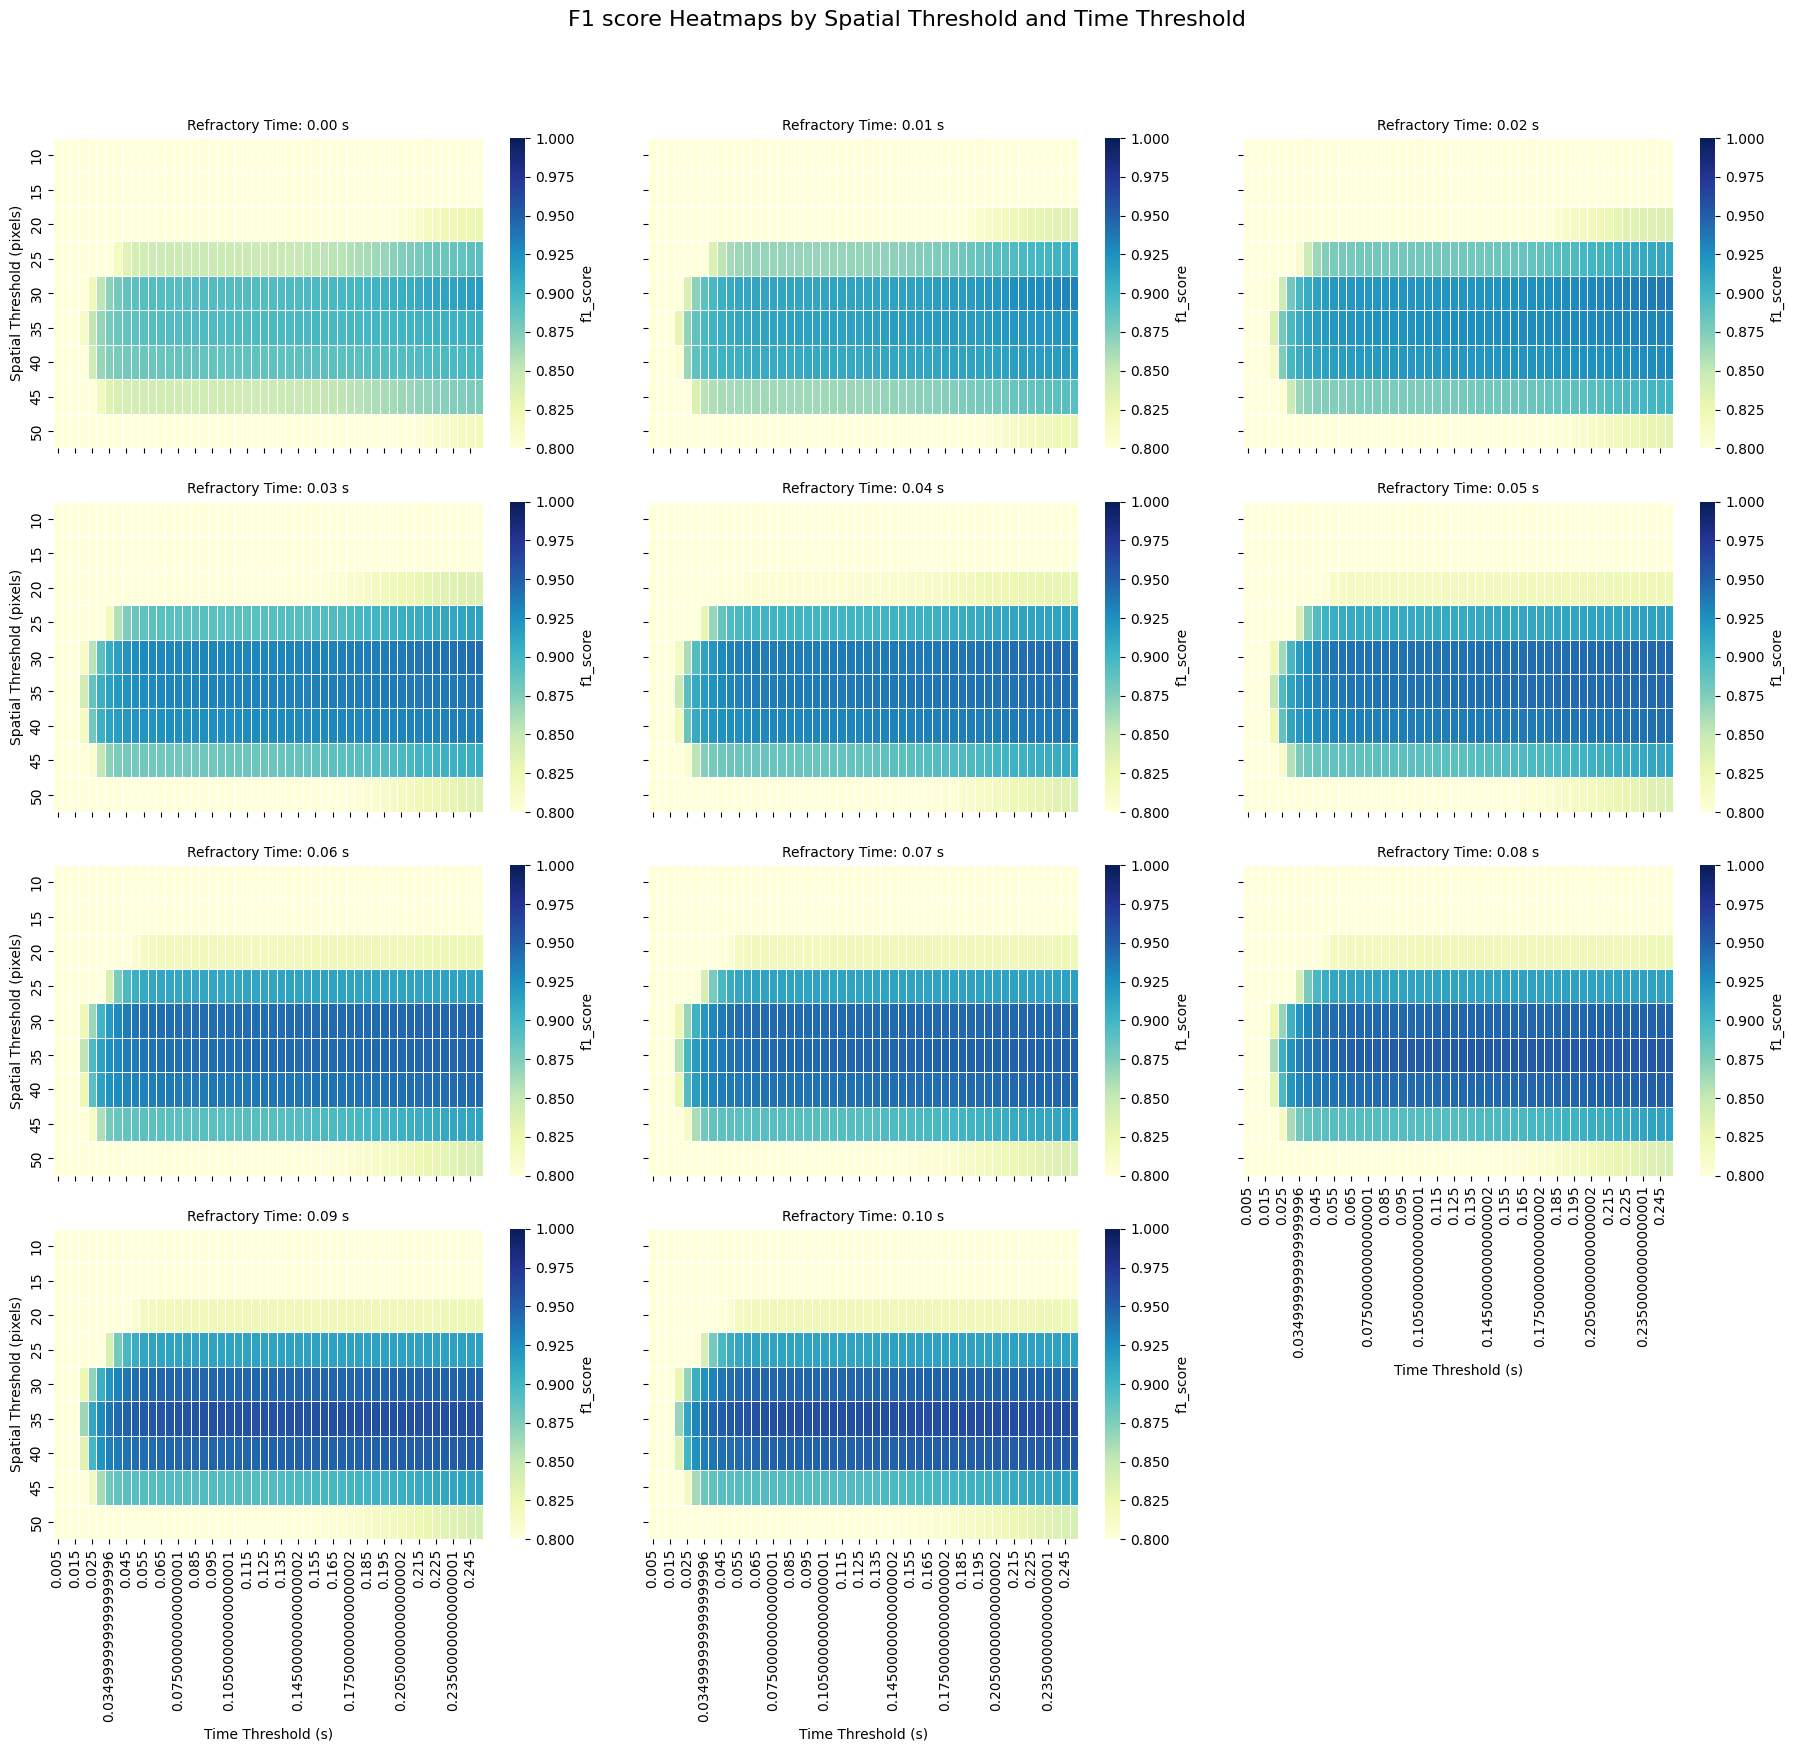

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a FacetGrid for recall
g = sns.FacetGrid(results_df, col="t_refractory", col_wrap=3, height=4, aspect=1.5)

# Loop through each unique t_refractory value
for k, t_refractory in enumerate(results_df['t_refractory'].unique()):
    # Filter the DataFrame for the current t_refractory value
    filtered_df = results_df[results_df['t_refractory'] == t_refractory]

    # Pivot the filtered data for recall
    pivot_data = filtered_df.pivot_table(index="spatial_threshold", 
                                          columns="time_threshold", 
                                          values="f1_score", 
                                          aggfunc='mean')

    # Create the heatmap for recall
    ax = g.axes[k]
    sns.heatmap(pivot_data, ax=ax, cmap='YlGnBu', 
                cbar_kws={'label': 'f1_score'}, 
                annot=False, linewidths=.5,
                vmin=0.8, vmax=1.0) # Adjust vmin/vmax based on expected range

    # Set title for the subplot
    ax.set_title(f'Refractory Time: {t_refractory:.2f} s')
        



# Customize the plots
g.set_axis_labels('Time Threshold (s)', 'Spatial Threshold (pixels)')
g.set_titles(col_template='Refractory Time: {col_name:.2f} s')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('F1 score Heatmaps by Spatial Threshold and Time Threshold', fontsize=16)

plt.show()


In [31]:
n = 10
# test_df = results_df.query('time_threshold <= 0.1 and t_refractory <= 0.05')
test_df = results_df

# Get the top N rows with the highest recall values
top_n_recall_rows = test_df.nlargest(n, 'f1_score')

# Display the top N rows
top_n_recall_rows

,spatial_threshold,time_threshold,t_refractory,true_positive,false_positive,false_negative,recall,false_negative_rate,precision,false_discovery_rate,f1_score
3298,35,0.245,0.1,5661,185,284,0.952229,0.047771,0.968354,0.031646,0.960224
3299,35,0.250,0.1,5661,185,284,0.952229,0.047771,0.968354,0.031646,0.960224
3291,35,0.210,0.1,5660,186,285,0.952061,0.047939,0.968183,0.031817,0.960054
3292,35,0.215,0.1,5660,186,285,0.952061,0.047939,0.968183,0.031817,0.960054
3293,35,0.220,0.1,5660,186,285,0.952061,0.047939,0.968183,0.031817,0.960054
3294,35,0.225,0.1,5660,186,285,0.952061,0.047939,0.968183,0.031817,0.960054
3295,35,0.230,0.1,5660,186,285,0.952061,0.047939,0.968183,0.031817,0.960054
3296,35,0.235,0.1,5660,186,285,0.952061,0.047939,0.968183,0.031817,0.960054
3297,35,0.240,0.1,5660,186,285,0.952061,0.047939,0.968183,0.031817,0.960054
3282,35,0.165,0.1,5658,188,287,0.951724,0.048276,0.967841,0.032159,0.959715


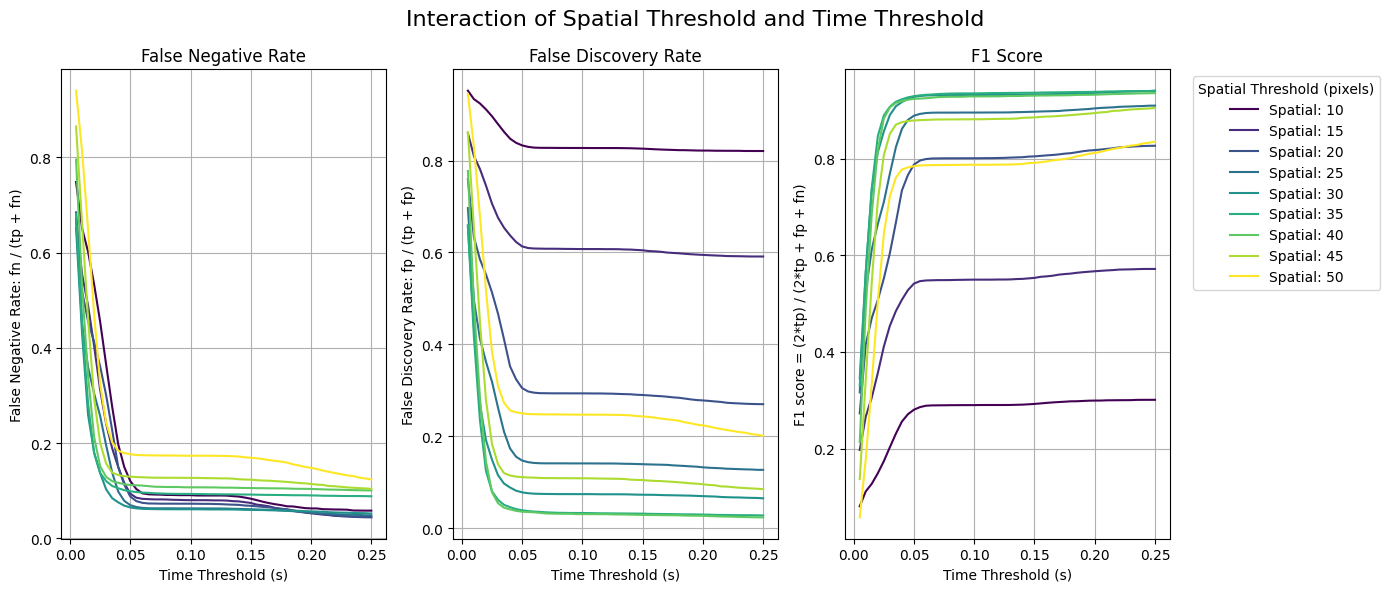

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming results_df is already defined

# Create interaction plot with subplots
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

# Group the DataFrame by 'time_threshold' and 'spatial_threshold' and calculate the mean of the relevant columns
grouped_df = results_df.groupby(['time_threshold', 'spatial_threshold']).mean().reset_index()

# Get unique spatial thresholds and define a colormap
unique_spatial_thresholds = grouped_df['spatial_threshold'].unique()
num_colors = len(unique_spatial_thresholds)
cmap = plt.get_cmap('viridis', num_colors)  # Use a colormap with enough distinct colors

# FNR interaction plot
for i, spatial_threshold in enumerate(unique_spatial_thresholds):
    # Filter DataFrame for the current spatial threshold
    filtered_df = grouped_df[grouped_df['spatial_threshold'] == spatial_threshold]
    
    # Plot the False Negative Rate
    axs[0].plot(filtered_df['time_threshold'], 
                 filtered_df['false_negative_rate'], 
                 label=f'Spatial: {spatial_threshold}', 
                 color=cmap(i))

axs[0].set_title('False Negative Rate')
axs[0].set_xlabel('Time Threshold (s)')
axs[0].set_ylabel('False Negative Rate: fn / (tp + fn)')
# axs[0].legend(title='Spatial Threshold (pixels)', bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].grid()

# FDR interaction plot
for i, spatial_threshold in enumerate(unique_spatial_thresholds):
    # Filter DataFrame for the current spatial threshold
    filtered_df = grouped_df[grouped_df['spatial_threshold'] == spatial_threshold]
    
    # Plot the False Discovery Rate
    axs[1].plot(filtered_df['time_threshold'], 
                 filtered_df['false_discovery_rate'], 
                 label=f'Spatial: {spatial_threshold}', 
                 color=cmap(i))

axs[1].set_title('False Discovery Rate')
axs[1].set_xlabel('Time Threshold (s)')
axs[1].set_ylabel('False Discovery Rate: fp / (tp + fp)')
# axs[1].legend(title='Spatial Threshold (pixels)', bbox_to_anchor=(1.05, 1), loc='upper left')
axs[1].grid()

# f1_score interaction plot
for i, spatial_threshold in enumerate(unique_spatial_thresholds):
    # Filter DataFrame for the current spatial threshold
    filtered_df = grouped_df[grouped_df['spatial_threshold'] == spatial_threshold]
    
    # Plot the False Discovery Rate
    axs[2].plot(filtered_df['time_threshold'], 
                 filtered_df['f1_score'], 
                 label=f'Spatial: {spatial_threshold}', 
                 color=cmap(i))

axs[2].set_title('F1 Score')
axs[2].set_xlabel('Time Threshold (s)')
axs[2].set_ylabel('F1 score = (2*tp) / (2*tp + fp + fn)')
axs[2].legend(title='Spatial Threshold (pixels)', bbox_to_anchor=(1.05, 1), loc='upper left')
axs[2].grid()

fig.suptitle('Interaction of Spatial Threshold and Time Threshold', fontsize=16)

plt.tight_layout()
plt.show()


Heatmap 1 Max - Spatial Threshold: 30, Time Threshold: 0.25, F1 Score: 0.94
Heatmap 2 Max - Spatial Threshold: 35, T Refractory: 0.1, F1 Score: 0.93
Heatmap 3 Max - Time Threshold: 0.25, T Refractory: 0.1, F1 Score: 0.80


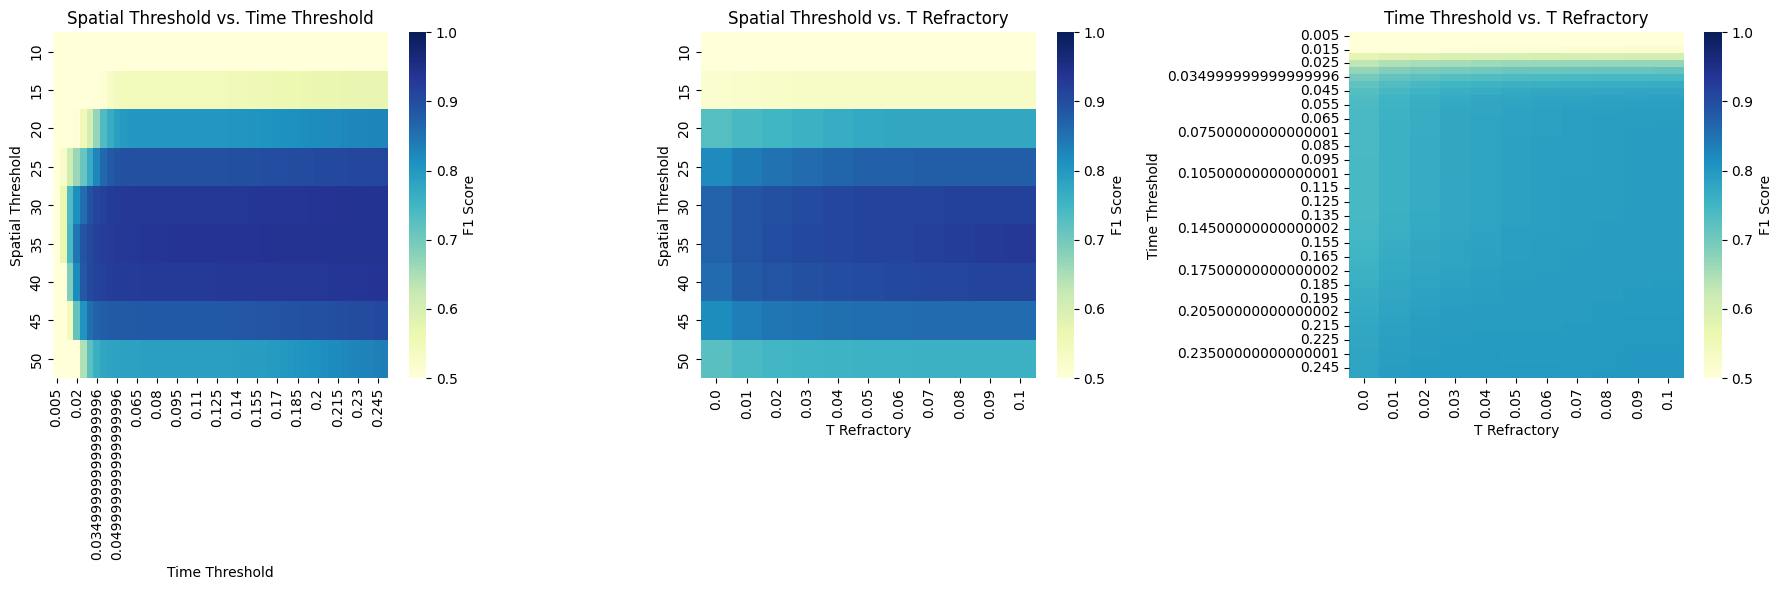

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with the relevant columns
df = results_df.copy()

# Define the color range for the heatmap
cmap_range_min = 0.5  # Set this to the minimum score you want to visualize
cmap_range_max = 1  # Set this to the maximum score you want to visualize

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Heatmap 1: spatial_threshold vs. time_threshold
heatmap_data1 = df.pivot_table(values='f1_score', index='spatial_threshold', columns='time_threshold')
sns.heatmap(heatmap_data1, ax=axs[0], cmap='YlGnBu', cbar_kws={'label': 'F1 Score'}, vmin=cmap_range_min, vmax=cmap_range_max)

# Find the max value and its position for heatmap 1
max_value1 = heatmap_data1.max().max()
max_pos1 = heatmap_data1.stack().idxmax()
spatial_threshold1, time_threshold1 = max_pos1
print(f"Heatmap 1 Max - Spatial Threshold: {spatial_threshold1}, Time Threshold: {time_threshold1}, F1 Score: {max_value1:.2f}")

axs[0].set_title('Spatial Threshold vs. Time Threshold')
axs[0].set_xlabel('Time Threshold')
axs[0].set_ylabel('Spatial Threshold')

# Heatmap 2: spatial_threshold vs. t_refractory
heatmap_data2 = df.pivot_table(values='f1_score', index='spatial_threshold', columns='t_refractory')
sns.heatmap(heatmap_data2, ax=axs[1], cmap='YlGnBu', cbar_kws={'label': 'F1 Score'}, vmin=cmap_range_min, vmax=cmap_range_max)

# Find the max value and its position for heatmap 2
max_value2 = heatmap_data2.max().max()
max_pos2 = heatmap_data2.stack().idxmax()
spatial_threshold2, t_refractory2 = max_pos2
print(f"Heatmap 2 Max - Spatial Threshold: {spatial_threshold2}, T Refractory: {t_refractory2}, F1 Score: {max_value2:.2f}")

axs[1].set_title('Spatial Threshold vs. T Refractory')
axs[1].set_xlabel('T Refractory')
axs[1].set_ylabel('Spatial Threshold')

# Heatmap 3: time_threshold vs. t_refractory
heatmap_data3 = df.pivot_table(values='f1_score', index='time_threshold', columns='t_refractory')
sns.heatmap(heatmap_data3, ax=axs[2], cmap='YlGnBu', cbar_kws={'label': 'F1 Score'}, vmin=cmap_range_min, vmax=cmap_range_max)

# Find the max value and its position for heatmap 3
max_value3 = heatmap_data3.max().max()
max_pos3 = heatmap_data3.stack().idxmax()
time_threshold3, t_refractory3 = max_pos3
print(f"Heatmap 3 Max - Time Threshold: {time_threshold3}, T Refractory: {t_refractory3}, F1 Score: {max_value3:.2f}")

axs[2].set_title('Time Threshold vs. T Refractory')
axs[2].set_xlabel('T Refractory')
axs[2].set_ylabel('Time Threshold')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [ ]:
# conclusions: unbiased search for best parameter would indicate pixel_threshold of 35. 
# also indicates maximizing both the refractory filter value, and the overlap threshold value, produces best performance
# however, unsure if this is truly warranted -- we want to avoid detecting two licks as 'the same' when in fact they are not. 
# --> pursue data-driven parameter selection

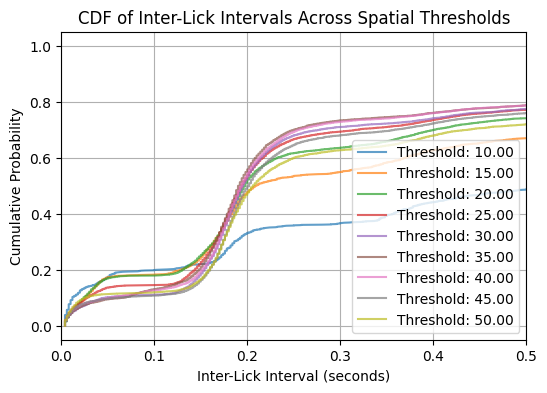

In [39]:
# let's motivate using the refractory filter by analyzing inter lick interval distribution

plt.figure(figsize=(6,4))

# Loop through spatial thresholds
for spatial_threshold in spatial_thresholds:
    # Detect licks based on spatial threshold
    LP_licks_temp = detect_licks(tongue_masked, mean_spoutL, mean_spoutR, spatial_threshold)

    ILIs = np.diff(LP_licks_temp)
    # Calculate and plot the CDF
    sorted_ILIs = np.sort(ILIs)
    cdf = np.arange(1, len(sorted_ILIs) + 1) / len(sorted_ILIs)
    plt.plot(sorted_ILIs, cdf, label=f'Threshold: {spatial_threshold:.2f}', alpha=0.7)


# Set x-axis limits
plt.xlim(0, 0.5)

# Customize the plot
plt.title('CDF of Inter-Lick Intervals Across Spatial Thresholds')
plt.xlabel('Inter-Lick Interval (seconds)')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid()
plt.show()



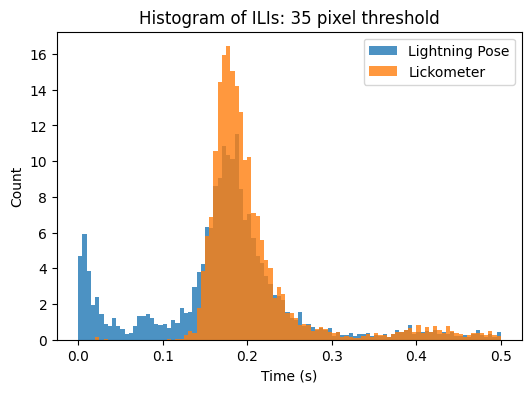

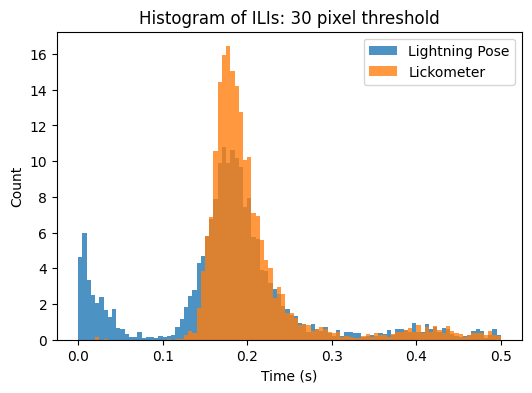

In [58]:
# from before, we know we want to use threshold of 35 pixels
spatial_threshold = 35
LP_licks = detect_licks(tongue_masked, mean_spoutL, mean_spoutR, spatial_threshold)

plt.figure(figsize=(6,4))
LP_lick_diffs = np.diff(LP_licks)
plt.hist(LP_lick_diffs,bins=100,range=[0,.5],alpha=0.8,density=True)
all_lick_diffs = np.diff(all_licks)
plt.hist(all_lick_diffs,bins=100,range=[0,.5],alpha=0.8,density=True)
plt.title(f'Histogram of ILIs: 35 pixel threshold')
plt.xlabel('Time (s)')
plt.ylabel('Count')
plt.legend(['Lightning Pose','Lickometer'])
plt.show()

spatial_threshold = 30
LP_licks = detect_licks(tongue_masked, mean_spoutL, mean_spoutR, spatial_threshold)

plt.figure(figsize=(6,4))
LP_lick_diffs = np.diff(LP_licks)
plt.hist(LP_lick_diffs,bins=100,range=[0,.5],alpha=0.8,density=True)
all_lick_diffs = np.diff(all_licks)
plt.hist(all_lick_diffs,bins=100,range=[0,.5],alpha=0.8,density=True)
plt.title(f'Histogram of ILIs: 30 pixel threshold')
plt.xlabel('Time (s)')
plt.ylabel('Count')
plt.legend(['Lightning Pose','Lickometer'])
plt.show()

In [69]:
# this seems to motivate filter of licks within 100ms of another lick.
# data seem cleaner for threshold of 30 pixels -- I wonder if ILIs around 100ms are being shifted 'longer', as they need to get closer to the spout. would imply these are real events
# motivates combination of 30 pixel, 100ms refractory filter. 

# Now, let's calculate basic metric curves with these parameters


# Set specific values for spatial threshold and refractory period
spatial_threshold = 30
t_refractory = 0.1
time_thresholds = np.arange(0.005, 0.251, 0.001)  
relevant_licks_temp = all_licks

# Initialize a list to collect results
results = []

# Detect licks based on the fixed spatial threshold
LP_licks_temp = detect_licks(tongue_masked, mean_spoutL, mean_spoutR, spatial_threshold)

# Filter detected licks based on the fixed t_refractory value
LP_licks_filtered = filter_timestamps_refractory(LP_licks_temp, t_refractory)

# Loop through time thresholds
for time_threshold in time_thresholds:
    tp, fp, fn = calculate_metrics(LP_licks_filtered, relevant_licks_temp, time_threshold)
    
    # Calculate additional metrics
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    false_negative_rate = fn / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    false_discovery_rate = fp / (tp + fp) if (tp + fp) > 0 else 0
    f1_score = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0  # harmonic mean of precision and recall
    
    # Append results to the list
    results.append({
        'spatial_threshold': spatial_threshold,
        'time_threshold': time_threshold,
        't_refractory': t_refractory,
        'true_positive': tp,
        'false_positive': fp,
        'false_negative': fn,
        'recall': recall,
        'false_negative_rate': false_negative_rate,
        'precision': precision,
        'false_discovery_rate': false_discovery_rate,
        'f1_score': f1_score
    })

# Convert results to a DataFrame
results_parameterized_df = pd.DataFrame(results)



Filtered 690 events!


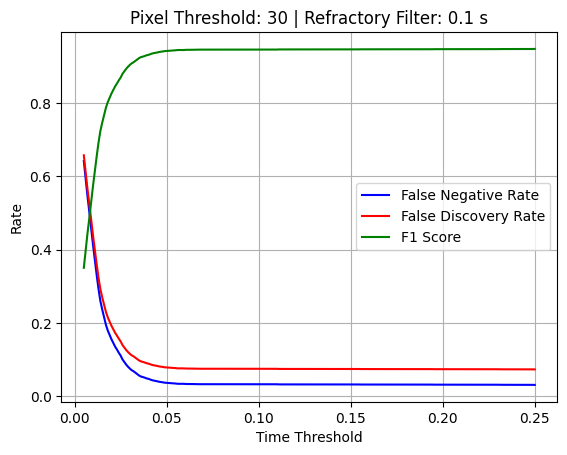

In [70]:
import matplotlib.pyplot as plt

# Extract relevant data from the DataFrame
time_thresholds = results_parameterized_df['time_threshold']
false_negative_rate = results_parameterized_df['false_negative_rate']
false_discovery_rate = results_parameterized_df['false_discovery_rate']
f1_score = results_parameterized_df['f1_score']

# Create a figure and axis
fig, ax1 = plt.subplots()

# Plot false_negative_rate and false_discovery_rate on the first axis
ax1.plot(time_thresholds, false_negative_rate, label='False Negative Rate', color='b')
ax1.plot(time_thresholds, false_discovery_rate, label='False Discovery Rate', color='r')
ax1.plot(time_thresholds, f1_score, label='F1 Score', color='g')  # Added F1 Score to the same plot

# Set labels
ax1.set_xlabel('Time Threshold')
ax1.set_ylabel('Rate', color='k')
ax1.tick_params(axis='y', labelcolor='k')

# Add legend
ax1.legend(loc='center right')

# Add a title and grid
plt.title('Pixel Threshold: 30 | Refractory Filter: 0.1 s')
ax1.grid()

# Show the plot
plt.show()


In [75]:
# 100 ms seems like a safe time overlap threshold as well. 
# final stats:
chosen_row = results_parameterized_df.query('time_threshold == 0.1')
chosen_row

,spatial_threshold,time_threshold,t_refractory,true_positive,false_positive,false_negative,recall,false_negative_rate,precision,false_discovery_rate,f1_score
95,30,0.1,0.1,5411,435,180,0.967805,0.032195,0.92559,0.07441,0.946227
